# Part 2 Linear rainfall-runoff 

| Symbol       | Betydning                                                                                                    |
| ------------ | ------------------------------------------------------------------------------------------------------------ |
| ( U_t )      | Nedbørsintensiteten (regn over tid), inngangsdata                                                            |
| ( A )        | Nedbørsfeltets areal (fangstområde) – hvor stort område som samler opp regn                                  |
| ( X_i )      | Vannmengden i reservoar nr. i (typisk representerer ulike hydrologiske prosesser: overflate, grunnvann osv.) |
| ( K )        | Tidskonstant – bestemmer hvor raskt vannet renner ut av reservoarene                                         |
| ( n )        | Antall reservoarer minus én (brukes som skalering)                                                           |
| ( \sigma )   | Styrken på støy (usikkerhet), kan være konstant eller ulik for hvert reservoar                               |
| ( dW_{i,t} ) | Wienerprosess (stokastisk støy, representerer tilfeldige svingninger)                                        |


In [3]:

# Load package
library(e1071)
library(ctsmTMB)
library(dplyr)
# library(lubridate)
library(readr)

###       PART 2       ###

data <- read.csv("data/ex1_rainfallrunoff.csv")


# build the data frame the model expects
data <- data %>%
  mutate(
    time = as.POSIXct(timestamp, format = "%Y-%m-%d %H:%M:%S", tz = "UTC"),
    t = as.numeric(difftime(time, min(time), units = "hour"))
  ) %>%
  arrange(t) %>%
  select(t, rainfall, stormwater)

#data$t <- data$t/60

tail(data)


,t,rainfall,stormwater
,<dbl>,<dbl>,<dbl>
596,9.916667,0,51.327
597,9.933333,0,51.006
598,9.950000,0,51.504
599,9.966667,0,51.816
600,9.983333,0,51.512
601,10.000000,0,52.146



## 2.1 Linear rainfall-runoff

### 2.1.1

In [4]:
model <- ctsmTMB$new()

# Differential Equation
model$addSystem(
  dx1 ~ A * rainfall * dt - (1/K) * x1 * dt + sigma_x * dw1,
  dx2 ~ (1/K) * x1 * dt + sigma_x * dw2
)

#Parameters and estimation
model$addObs(stormwater ~ x2)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 1,  lower = 1e-6, upper = 1e3),
  K       = c(initial = 10, lower = 1e-6, upper = 1e4),
  sigma_x = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y = c(initial = 0.1, lower = 1e-8, upper = 10)
)
model$setInitialState(list(c( 0, 0), diag(c(0.1, 0.1))
))

# now estimate
fit <- model$estimate(data)

summary(fit)
print(fit)



Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     24354.006:  1.00000  10.0000 0.100000 0.100000
 10:     219.54677:  6.45299  2.92458  1.20231 0.262834


	 Optimization finished!:
            Elapsed time: 0.027 seconds.
            The objective value is: 2.182204e+02
            The maximum gradient component is: 9.3e-04
            The convergence message is: relative convergence (4)
            Iterations: 18
            Evaluations: Fun: 28 Grad: 19
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       6.2469907  0.4659510  13.407 < 2.2e-16 ***
K       2.9815752  0.2895614  10.297 < 2.2e-16 ***
sigma_x 1.0831228  0.0773761  13.998 < 2.2e-16 ***
sigma_y 0.2687601  0.0097427  27.586 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       6.2469907  0.4659510  13.407 < 2.2e-16 ***
K       2.9815752  0.2895614  10.297 < 2.2e-16 ***
sigma_x 1.0831228  0.0773761  13.998 < 2.2e-16 ***
sigma_y 0.2687601  0.0097427  27.586 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


,t,rainfall,stormwater
,<dbl>,<dbl>,<dbl>
1,0.00000000,0.003,0
2,0.01666667,0.000,0
3,0.03333333,0.000,0
4,0.05000000,0.000,0
5,0.06666667,0.000,0
6,0.08333333,0.000,0


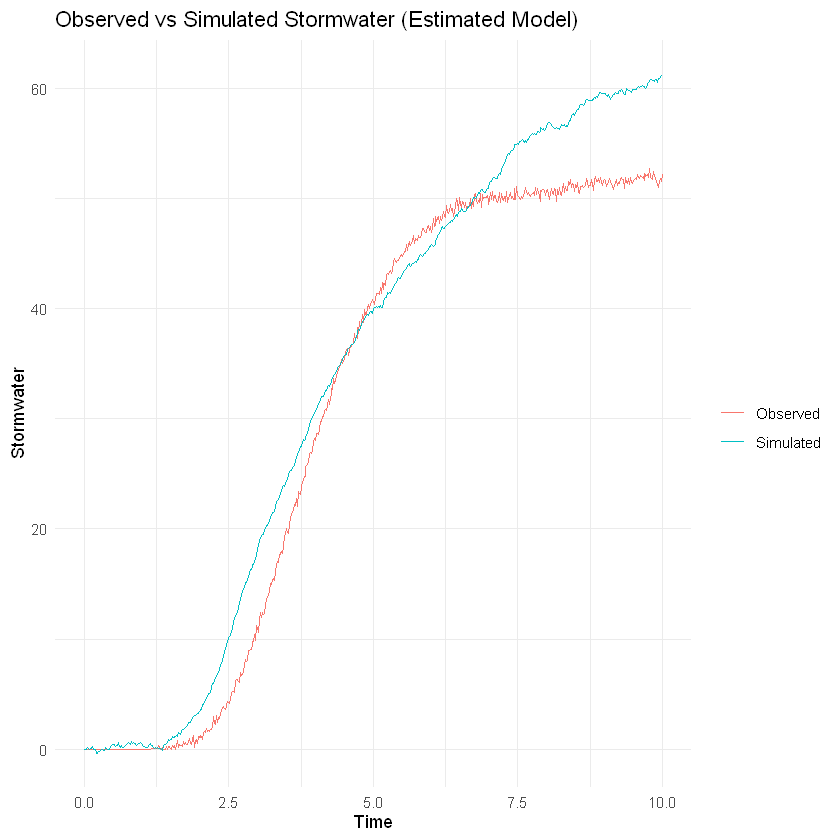

,t,rainfall,stormwater
,<dbl>,<dbl>,<dbl>
596,9.916667,0,51.327
597,9.933333,0,51.006
598,9.950000,0,51.504
599,9.966667,0,51.816
600,9.983333,0,51.512
601,10.000000,0,52.146


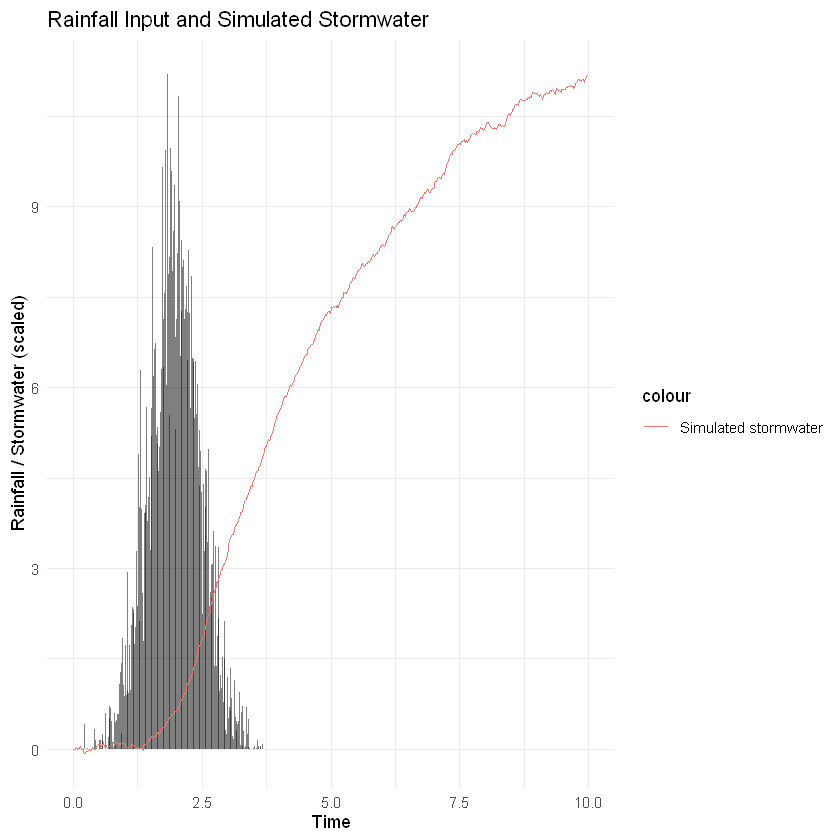

In [ ]:
# ---- Libraries
library(ggplot2)

# ---- Coefficients from fit
A <- 6.2798
K <- 2.9542
sigma_x <- 1.0207
sigma_y <- 0.27065

# ---- Simulate model dynamics (match the time units used in estimation!)
time <- if ("t" %in% names(data)) data$t else data$time

time_num <- as.numeric(time)     # keep as-is if already numeric
n <- nrow(data)
x1 <- numeric(n)
x2 <- numeric(n)

# Handle missing rainfall so it doesn't propagate NAs
rain <- data$rainfall
rain[!is.finite(rain)] <- 0

set.seed(123)
for (i in 2:n) {
  dt_i <- time_num[i] - time_num[i-1]        # <- correct time step in model units
  stopifnot(is.finite(dt_i) && dt_i > 0)

  # Brownian increments scale with sqrt(dt)
  dw1 <- rnorm(1, 0, sqrt(dt_i))
  dw2 <- rnorm(1, 0, sqrt(dt_i))

  # Euler–Maruyama
  x1[i] <- x1[i-1] + (A * rain[i] - (1/K) * x1[i-1]) * dt_i + sigma_x * dw1
  x2[i] <- x2[i-1] + ((1/K) * x1[i-1])              * dt_i + sigma_x * dw2
}

# For comparison to observations, DON'T add measurement noise:
stormwater_sim <- x2
# If you really want noisy observations, use:
# stormwater_sim <- x2 + rnorm(n, 0, sigma_y)


# ---- Combine with observed data
df_plot <- data.frame(
  time = data$t,
  observed = data$stormwater,
  simulated = stormwater_sim,
  rainfall = data$rainfall
)

head(data)
# ---- Plot: observed vs simulated stormwater
ggplot(df_plot, aes(x = time)) +
  geom_line(aes(y = observed, color = "Observed")) +
  geom_line(aes(y = simulated, color = "Simulated")) +
  labs(title = "Observed vs Simulated Stormwater (Estimated Model)",
       y = "Stormwater", x = "Time", color = "") +
  theme_minimal()

# ---- Optional: rainfall overlay
ggplot(df_plot, aes(x = time)) +
  geom_col(aes(y = rainfall), fill = "black", alpha = 0.5) +
  geom_line(aes(y = simulated / max(simulated) * max(rainfall),
                color = "Simulated stormwater")) +
  labs(title = "Rainfall Input and Simulated Stormwater",
       y = "Rainfall / Stormwater (scaled)", x = "Time") +
  theme_minimal()

  tail(data)

### 2.1.2

In [ ]:
model <- ctsmTMB$new()

# Differential Equation
n = 2

model$addSystem(
  dx1 ~ A * rainfall * dt - (2/K) * x1 * dt + sigma_x * dw1,
  dx2 ~ (2/K) * x1 * dt - (2/K) * x2 * dt + sigma_x * dw2,
  dx3 ~ (2/K) * x2 * dt + sigma_x * dw3
)

#Parameters and estimation
model$addObs(stormwater ~ x3)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 1,  lower = 1e-6, upper = 1e3),
  K       = c(initial = 10, lower = 1e-6, upper = 1e4),
  sigma_x = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y = c(initial = 0.1, lower = 1e-8, upper = 10)
)
model$setInitialState(list(c( 0, 0, 0), diag(c(0.1, 0.1, 0.1))))

# now estimate
fit <- model$estimate(data)

summary(fit)
print(fit)



Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     21283.299:  1.00000  10.0000 0.100000 0.100000
 10:     300.75575:  1.72669  9.47260  1.69683 0.234096
 20:     173.47971:  6.09825  2.39469 0.694121 0.287735
 30:     166.66062:  5.58086  2.23318 0.499815 0.284131


	 Optimization finished!:
            Elapsed time: 0.07 seconds.
            The objective value is: 1.666606e+02
            The maximum gradient component is: 5.3e-04
            The convergence message is: relative convergence (4)
            Iterations: 33
            Evaluations: Fun: 52 Grad: 34
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       5.5806196  0.1940443 28.7595 < 2.2e-16 ***
K       2.2331765  0.0708967 31.4990 < 2.2e-16 ***
sigma_x 0.4998592  0.0544462  9.1808 < 2.2e-16 ***
sigma_y 0.2841016  0.0090212 31.4928 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       5.5806196  0.1940443 28.7595 < 2.2e-16 ***
K       2.2331765  0.0708967 31.4990 < 2.2e-16 ***
sigma_x 0.4998592  0.0544462  9.1808 < 2.2e-16 ***
sigma_y 0.2841016  0.0090212 31.4928 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [ ]:
library(ctsmTMB)

## choose n
n <- 3             
print("Number of Resoars:")
print(n)

n_states <- n + 1 

model <- ctsmTMB$new()

## Diff for loop
for (i in 1:n_states) {

  if (i == 1) {
    # Første reservoar: får nedbør inn
    rhs <- paste0("A * rainfall * dt - (", n, "/K) * x1 * dt + sigma_x * dw1")
  } else if (i < n_states) {
    # Mellomliggende reservoarer
    rhs <- paste0("(", n, "/K) * x", i - 1,
                  " * dt - (", n, "/K) * x", i,
                  " * dt + sigma_x * dw", i)
  } else {
    # Siste reservoar: kun utstrømning videre (runoff)
    rhs <- paste0("(", n, "/K) * x", i - 1,
                  " * dt + sigma_x * dw", i)
  }

  lhs <- paste0("dx", i)
  eq  <- as.formula(paste(lhs, rhs, sep = " ~ "))

  model$addSystem(eq)
}

## Observasjonen skal være siste tilstand: x_{n+1}
obs_formula <- as.formula(paste0("stormwater ~ x", n_states))
model$addObs(obs_formula)

## noise
model$setVariance(stormwater ~ sigma_y^2)

## rainfall
model$addInput(rainfall)

## Parametre
model$setParameter(
  A       = c(initial = 1,   lower = 1e-6, upper = 1e3),
  K       = c(initial = 10,  lower = 1e-6, upper = 1e4),
  sigma_x = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y = c(initial = 0.1, lower = 1e-8, upper = 10)
)

## Initialtilstand: middelverdi og kovarians
x0 <- rep(0, n_states)
P0 <- diag(rep(0.1, n_states))

model$setInitialState(list(x0, P0))

## Estimer modellen
fit <- model$estimate(data)


summary(fit)
print(fit)



[1] "Number of Resoars:"
[1] 3


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     18715.797:  1.00000  10.0000 0.100000 0.100000
 10:     294.98148:  1.49400  8.70752  1.60947 0.264592
 20:     228.60930:  3.52849  2.71834  1.59945 0.254497
 30:     219.62687:  3.58861  2.56662  1.45439 0.259188
 40:     210.38350:  3.64750  2.42397  1.30469 0.264153
 50:     200.98706:  3.71026  2.28009  1.15507 0.268717
 60:     191.67291:  3.77868  2.13656  1.00679 0.272863
 70:     183.06911:  3.85662  1.99746 0.863636 0.276527
 80:     175.90570:  4.00085  1.91403 0.738426 0.280324
 90:     169.51164:  4.19790  1.94791 0.628426 0.285181
100:     153.61287:  5.06471  2.04119 0.362918 0.286250
110:     152.93899:  5.03541  2.03929 0.325093 0.288146
120:     152.72344:  5.00199  2.04082 0.295962 0.290114


	 Optimization finished!:
            Elapsed time: 0.29 seconds.
            The objective value is: 1.527224e+02
            The maximum gradient component is: 1.5e-04
            The convergence message is: relative convergence (4)
            Iterations: 124
            Evaluations: Fun: 149 Grad: 125
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       5.0056322  0.1161926 43.0805 < 2.2e-16 ***
K       2.0414807  0.0386726 52.7888 < 2.2e-16 ***
sigma_x 0.2946668  0.0500568  5.8867 6.555e-09 ***
sigma_y 0.2903437  0.0090344 32.1376 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       5.0056322  0.1161926 43.0805 < 2.2e-16 ***
K       2.0414807  0.0386726 52.7888 < 2.2e-16 ***
sigma_x 0.2946668  0.0500568  5.8867 6.555e-09 ***
sigma_y 0.2903437  0.0090344 32.1376 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Number of reservoirs (n): 3 
Number of states: 4 


,time,observed,simulated,rainfall
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00000000,0,0.000000000,0.003
2,0.01666667,0,0.002673159,0.000
3,0.03333333,0,-0.043841308,0.000
4,0.05000000,0,-0.028365182,0.000
5,0.06666667,0,0.042341309,0.000
6,0.08333333,0,0.026810225,0.000


,time,observed,simulated,rainfall
,<dbl>,<dbl>,<dbl>,<dbl>
596,9.916667,51.327,51.92009,0
597,9.933333,51.006,51.96822,0
598,9.950000,51.504,51.94526,0
599,9.966667,51.816,51.91336,0
600,9.983333,51.512,51.86461,0
601,10.000000,52.146,51.89493,0


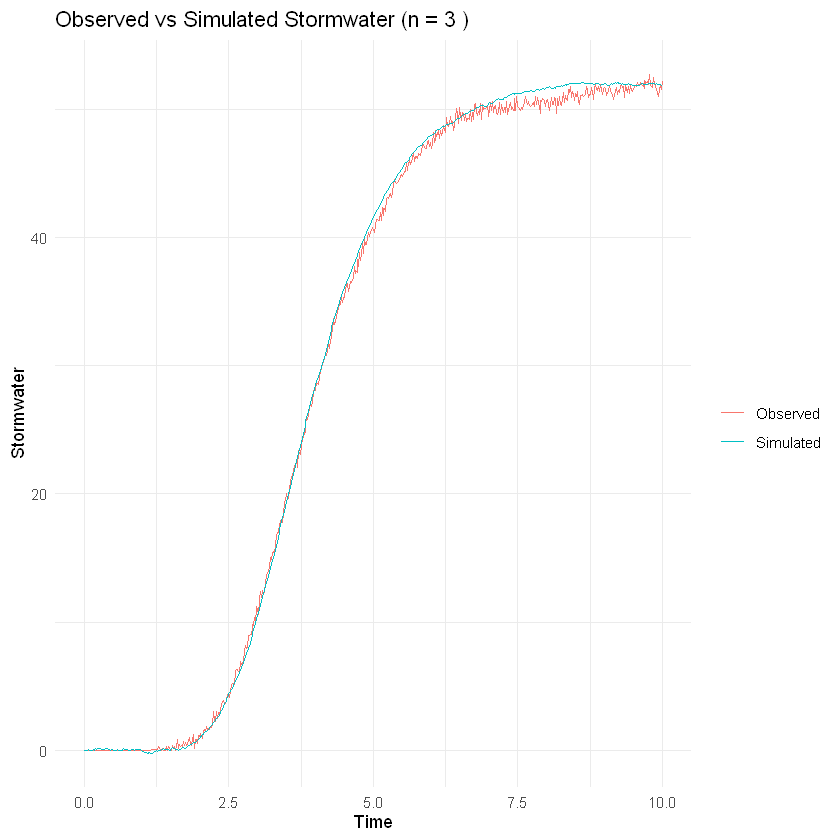

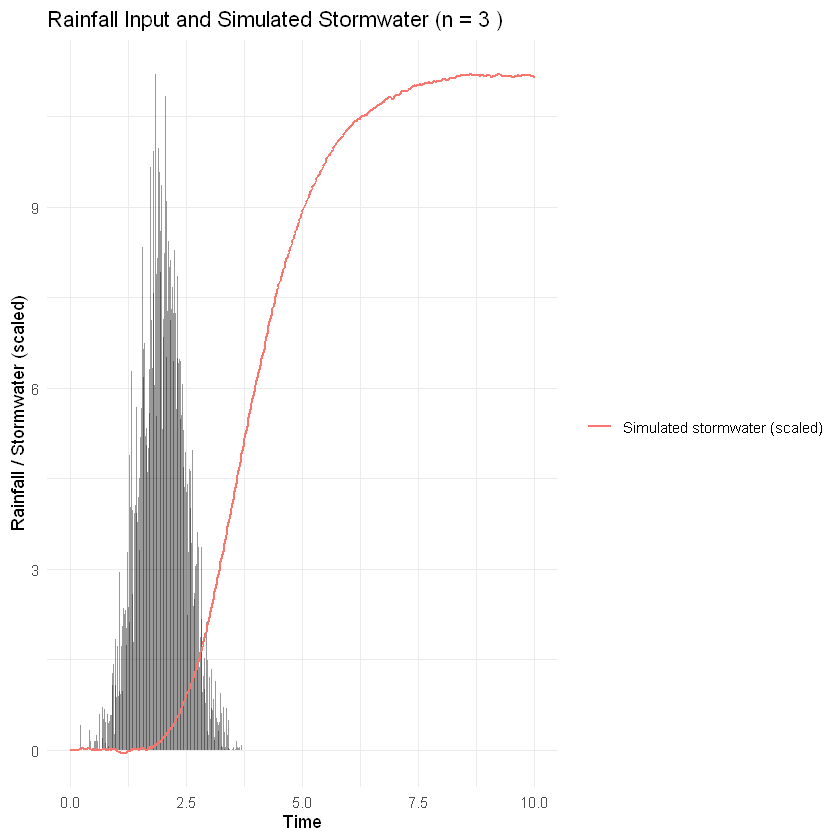

In [ ]:
# ---- Libraries
library(ggplot2)

# ---- Choose n (same n as in your ctsmTMB model) ----
n <- 3                 # e.g. 1, 2, 3, ..., 6
n_states <- n + 1      # x1, x2, ..., x_{n+1}

cat("Number of reservoirs (n):", n, "\n")
cat("Number of states:", n_states, "\n")

# ---- Coefficients from fit (or take from coef(fit)) ----
A       <- 5.0056
K       <- 2.0415
sigma_x <- 0.29367
sigma_y <- 0.29034

# Time handling 
time <- if ("t" %in% names(data)) data$t else data$time
time_num <- as.numeric(time)
n_t <- length(time_num)

rain <- data$rainfall
rain[!is.finite(rain)] <- 0

# State matrix: rows = time, cols = x1..x_{n+1} 
X <- matrix(0, nrow = n_t, ncol = n_states)
colnames(X) <- paste0("x", 1:n_states)

set.seed(123)

# Euler–Maruyama simulation matching your SDE structure 
for (i in 2:n_t) {
  dt_i <- time_num[i] - time_num[i - 1]
  stopifnot(is.finite(dt_i) && dt_i > 0)

  # Brownian increments for each state
  dw <- rnorm(n_states, mean = 0, sd = sqrt(dt_i))

  # previous state
  x_prev <- X[i - 1, ]

  # 1) First reservoir:
  
  X[i, 1] <- x_prev[1] +
    (A * rain[i] - (n / K) * x_prev[1]) * dt_i +
    sigma_x * dw[1]

  # 2) Middle reservoirs (if any)
  if (n_states > 2) {
    for (k in 2:(n_states - 1)) {
      # dx_k = (n/K)*x_{k-1} - (n/K)*x_k + noise
      X[i, k] <- x_prev[k] +
        ((n / K) * x_prev[k - 1] - (n / K) * x_prev[k]) * dt_i +
        sigma_x * dw[k]
    }
  }

  # 3) Last reservoir:
  X[i, n_states] <- x_prev[n_states] +
    ( (n / K) * x_prev[n_states - 1] ) * dt_i +
    sigma_x * dw[n_states]
}

# Runoff / stormwater = last state x_{n+1} 
stormwater_sim <- X[, n_states]


df_plot <- data.frame(
  time      = time,
  observed  = data$stormwater,
  simulated = stormwater_sim,
  rainfall  = data$rainfall
)


# Plot 1: Observed vs simulated stormwater 
ggplot(df_plot, aes(x = time)) +
  geom_line(aes(y = observed,  color = "Observed")) +
  geom_line(aes(y = simulated, color = "Simulated")) +
  labs(title = paste("Observed vs Simulated Stormwater (n =", n, ")"),
       y = "Stormwater", x = "Time", color = "") +
  theme_minimal()

# Plot 2: Rainfall + simulated stormwater 
sim_scaled <- stormwater_sim / max(stormwater_sim, na.rm = TRUE) *
              max(df_plot$rainfall, na.rm = TRUE)

df_plot$sim_scaled <- sim_scaled

ggplot(df_plot, aes(x = time)) +
  geom_col(aes(y = rainfall), fill = "black", alpha = 0.4) +
  geom_line(aes(y = sim_scaled, color = "Simulated stormwater (scaled)"),
            linewidth = 0.8) +
  labs(title = paste("Rainfall Input and Simulated Stormwater (n =", n, ")"),
       y = "Rainfall / Stormwater (scaled)", x = "Time", color = "") +
  theme_minimal()
